In [15]:
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.layers import Conv2D, Flatten
from tensorflow.keras.layers import Reshape, Conv2DTranspose
from tensorflow.keras.models import Model
from tensorflow.keras.datasets import mnist
from tensorflow.keras.utils import plot_model
from tensorflow.keras import backend as K
import numpy as np
import matplotlib.pyplot as plt
from imutils import paths # import the paths submodule from imutils
from sklearn.model_selection import train_test_split
import cv2
from google.colab import drive

drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [49]:
print("[INFO] loading images...")
imagePaths = list(paths.list_images("/content/drive/MyDrive/content"))
data = []
labels = []

for imagePath in imagePaths:
	# label = imagePath.split(os.path.sep)[-2]
	image = cv2.imread(imagePath,0)
	# image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
	image = cv2.resize(image, (224, 224))

	data.append(image)
	# labels.append(label)

data = np.array(data) / 255.0

# load MNIST dataset
# (x_train, _), (x_test, _) = train_test_split(np.arange(len(data)), test_size=0.2, random_state=42)

[INFO] loading images...


In [50]:
x_train = (data[1])
x_test = (data[0])

In [52]:
print("train data:",x_train.shape)
print("test data:",x_test.shape)

image_size = x_train.shape[1]
x_train = np.reshape(x_train, [-1, image_size, image_size, 1])
x_test = np.reshape(x_test, [-1, image_size, image_size, 1])

train data: (224, 224)
test data: (224, 224)


In [53]:
print("train after reshape:",x_train.shape)
print("test after reshape:",x_test.shape)

train after reshape: (1, 224, 224, 1)
test after reshape: (1, 224, 224, 1)


In [54]:
x_train = x_train.astype('float32') / 255
x_test = x_test.astype('float32') / 255

In [55]:
# network parameters
input_shape = (image_size, image_size, 1)
batch_size = 32
kernel_size = 3
latent_dim = 16
# encoder/decoder number of CNN layers and filters per layer
layer_filters = [32, 64]

In [56]:
# build the autoencoder model
# first build the encoder model
inputs = Input(shape=input_shape, name='encoder_input')
x = inputs
# stack of Conv2D(32)-Conv2D(64)
for filters in layer_filters:
    x = Conv2D(filters=filters,
    kernel_size=kernel_size,
    activation='relu',
    strides=2,
    padding='same')(x)

In [57]:
shape = K.int_shape(x)
shape

(None, 56, 56, 64)

In [58]:
# generate latent vector
x = Flatten()(x)
latent = Dense(latent_dim, name='latent_vector')(x)
# instantiate encoder model
encoder = Model(inputs,
latent,
name='encoder')
encoder.summary()

Model: "encoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ encoder_input (InputLayer)           │ (None, 224, 224, 1)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 112, 112, 32)        │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 56, 56, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_2 (Flatten)                  │ (None, 200704)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ latent_vector (Dense)                │ (None, 16)                  │       3,211,280 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 3,230,096 (12.32 MB)

 Trainable params: 3,230,096 (12.32 MB)

 Non-trainable params: 0 (0.00 B)

In [59]:
# build the decoder model
latent_inputs = Input(shape=(latent_dim,), name='decoder_input')
# use the shape (, 7, 64) that was earlier saved
x = Dense(shape[1] * shape[2] * shape[3])(latent_inputs)
# from vector to suitable shape for transposed conv
x = Reshape((shape[1], shape[2], shape[3]))(x)

In [60]:
for filters in layer_filters[::-1]:
            x = Conv2DTranspose(filters=filters, kernel_size=kernel_size,activation='relu',strides=2,  padding='same')(x)

In [61]:
outputs = Conv2DTranspose(filters=1,
                                    kernel_size=kernel_size,
                                    activation='sigmoid',
                                    padding='same',
                                    name='decoder_output')(x)

In [62]:
decoder = Model(latent_inputs, outputs, name='decoder')
decoder.summary()

Model: "decoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ decoder_input (InputLayer)           │ (None, 16)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 200704)              │       3,411,968 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ reshape_2 (Reshape)                  │ (None, 56, 56, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose_4 (Conv2DTranspose) │ (None, 112, 112, 64)        │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose_5 (Conv2DTranspose) │ (None, 224, 224, 32)        │          18,464 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ decoder_output (Conv2DTranspose)     │ (None, 224, 224, 1)         │             289 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 3,467,649 (13.23 MB)

 Trainable params: 3,467,649 (13.23 MB)

 Non-trainable params: 0 (0.00 B)

In [63]:
autoencoder = Model(inputs,
                            decoder(encoder(inputs)),
                            name='autoencoder')
autoencoder.summary()

Model: "autoencoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ encoder_input (InputLayer)           │ (None, 224, 224, 1)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ encoder (Functional)                 │ (None, 16)                  │       3,230,096 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ decoder (Functional)                 │ (None, 224, 224, 1)         │       3,467,649 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 6,697,745 (25.55 MB)

 Trainable params: 6,697,745 (25.55 MB)

 Non-trainable params: 0 (0.00 B)

In [64]:
autoencoder.compile(loss='mse', optimizer='adam')

In [65]:
autoencoder.fit(x_train,
                        x_train,
                        validation_data=(x_test, x_test),
                        epochs=3,
                        batch_size=batch_size)

Epoch 1/3
1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step - loss: 0.2478 - val_loss: 0.2462
Epoch 2/3
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 297ms/step - loss: 0.2467 - val_loss: 0.2451
Epoch 3/3
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 275ms/step - loss: 0.2456 - val_loss: 0.2439


In [66]:
x_decoded = autoencoder.predict(x_test)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step


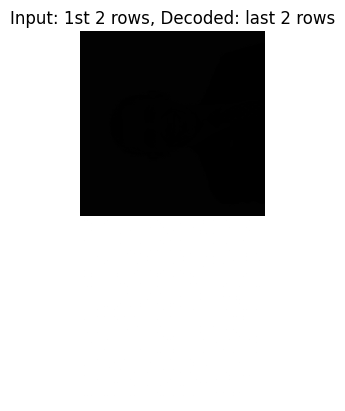

In [68]:
imgs = np.concatenate([x_test[:8], x_decoded[:8]])
#imgs = imgs.reshape((4, 4, image_size, image_size))
imgs = np.vstack([np.hstack(i) for i in imgs])
plt.figure()
plt.axis('off')
plt.title('Input: 1st 2 rows, Decoded: last 2 rows')
plt.imshow(imgs, interpolation='none', cmap='gray')
plt.savefig('input_and_decoded.png')
plt.show()